# Kelp Plants & Discrete and multi-level models

Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares, and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

I'll fit an appropriate discrete count model for this dataset to estimate the number of kelps in the missing cells.

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

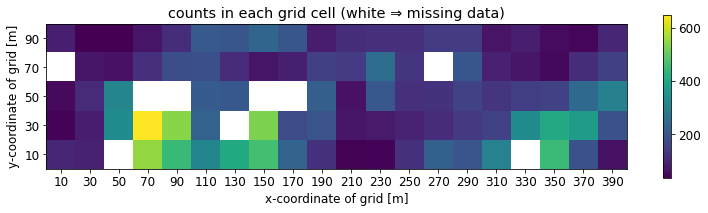

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

# Filtering and plotting data

In [5]:
import math
lst = [element for nestedlist in data for element in nestedlist]
lst = [value for value in lst if not math.isnan(value)]

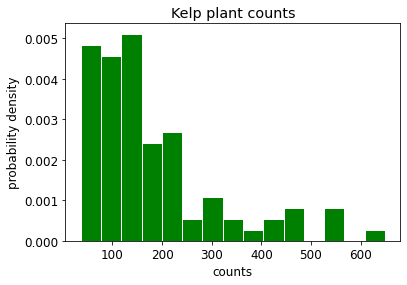

In [6]:
plt.figure()
plt.title('Kelp plant counts')
plt.xlabel('counts')
plt.ylabel('probability density')
plt.hist(lst, bins = 15, edgecolor='white', color = 'green', density=True)
plt.show()

In [109]:
round(np.mean(lst)), np.std(lst), min(lst), max(lst)

(181, 130.50075496891975, 36.0, 649.0)

# Strategy 

I suggest using a Poisson regression model to predict plant counts in the cells. 

It is a popular generalized linear model that allows us to analyze discrete variables based on the data we already have. Since we are predicting numbers of kelps, which is a discrete variable, Poisson is a good fit. 

Besides, this model doesn't expect us to know the maximum counts per cell, which helps us avoid making extra assumptions about the phenomena. We can just estimate the average number of plants in each tile and fit the model to the data gathered.  

After we set up a Poisson model that matches our beliefs about the plants' per-cell count distribution, we can see which distribution parameters that dictate its shape seem to be the most realistic. To do so, we will look at the posterior distribution of the parameters. Then we use those parameters to create a new Poisson distribution that allows us to predict counts in the unknown cells. 

You might have heard about the posterior predictive sample that allows us to see predictions about the counts using just the first model we create. However, we cannot use it for predicting unknown groups as it doesn't allow us to make predictions about the units from which we don't have any data. 

Finally, we can sample 9 random values from the newly created Poisson model to predict the numbers of kelps in the 9 unknown cells. 

# Importing everything needed

In [8]:
import arviz as az
import pandas as pd
import pymc as pm
import scipy.stats as sts
import aesara.tensor as at
import random as rd

az.rcParams['stats.hdi_prob'] = 0.89  # set credible interval for entire notebook
RANDOM_SEED = 8927

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Complete pooling 

There are different ways to set up a model, and in this report, I will cover the ones that are based on complete and partial pooling. 

Let's start with the first one. The idea of complete pooling is that we set the prior so that all the cells have the same parameter values for their distribution aka they all have the same shape. In this case, we assume that the counts in all cells must be very similar. 

Below, I am creating this model and setting the prior for the parameters of the Poisson model as an Exponential distribution. By definition, Poisson has to have positive parameters, and exponential distribution is a popular link function that will ensure that all the values we pass to Poisson are positive.

Moreover, the lambda parameter we pass to Poisson is basically the expected value for the counts per cell and the variance of the counts (aka how spread out they are.) I expect the lambda parameter to be around 400 because it is half the maximum count we expect per unit (max(1, 2)*400/2 = 800/2 = 400.) Therefore, the expected value of the exponential distribution must be ~400. The expected value of exponential distribution is 1/lam (here, lam is the parameter for Exponential distribution.) Therefore, I pass 1/400 as a parameter for my prior lam.

## Building a model

In [67]:
with pm.Model() as complete_pool:
    lam = pm.Exponential('lam', lam=1/400) #half of the max expected
    pm.Poisson('counts', lam, observed=lst)

In [68]:
with complete_pool:
    complete_inference = pm.sample(tune=3000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 88 seconds.
The acceptance probability does not match the target. It is 0.6951, but should be close to 0.8. Try to increase the number of tuning steps.


## Checking the reliability of the sampler

Below I am checking if my sampler for this model works well. Since r-hat is 1, both ess values are high, the rank plots for all chains are close to being uniform and cover the same ranges, we can believe that, most likely, my sampler doesn't have any computational errors. 

<b> Posterior summary for complete pooling model  

In [69]:
az.summary(complete_inference)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,180.512,1.467,178.091,182.763,0.038,0.027,1465.0,2430.0,1.0


<b> Plot distribution and sampled values

array([[<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

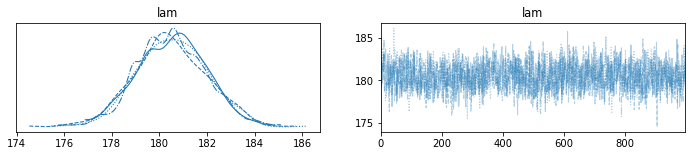

In [70]:
az.plot_trace(complete_inference, )

<b> Plot rank order statistics of chains.

<AxesSubplot:title={'center':'lam'}, xlabel='Rank (all chains)', ylabel='Chain'>

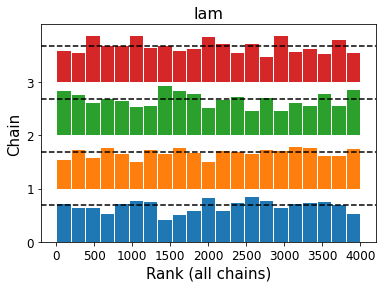

In [71]:
az.plot_rank(complete_inference, )

## Posterior over lambda

Now I will look at the posterior distribution over the lambda parameter. This distribution looks quite similar to a Normal distribution, meaning it is symmetrical and has only one mode with the most likely lambda value. The mean is around 180, and the range is [174, 186]. So, the model thinks that the range of the most likely lambda parameters is not that big, and lambda must be around 180. It is quite less than the mean value of 400 I anticipated, but it is still a very plausible value since most of the counts we have in the dataset are between 100 and 200. This model will predict the counts to be approximately [150, 250]. We anticipate a bit wider range than the one described for lambda to account not just for the expected value but also for the variation. 

In [72]:
complete_pool_post = complete_inference.posterior.lam.values.flat

C:\Users\kresh\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


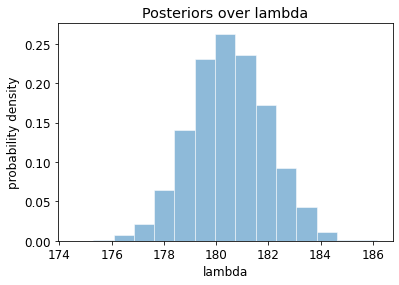

In [73]:
plt.figure()
plt.title('Posteriors over lambda')
plt.xlabel('lambda')
plt.ylabel('probability density')
for i in range(2):
    plt.hist(
        complete_pool_post, bins = 15, edgecolor='white', alpha=0.5, density=True)
plt.show()

## Posterior predictive sample

By sampling posterior predictive, I can look at the expected counts, given that the cells we predict are the same as the ones we already have data about. The plot below reinforces the claims made previously. The complete pooling model expects the counts to be more likely around 180 and the plausible range from ~120 to ~240.

Besides, it is worth noticing that the posterior predicitive plot looks very similar to the plot for posterior lambda. It happens to be so because lambda is the expected value of the numbers of plants and, therefore, using this posterior we'll get very similar posterior predictive which describes the same expected counts.

In [74]:
with complete_pool:
    complete_pool_sample = pm.sample_posterior_predictive(complete_inference)

In [83]:
complete_pool_pred = complete_pool_sample.posterior_predictive.counts.values.flat 

C:\Users\kresh\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


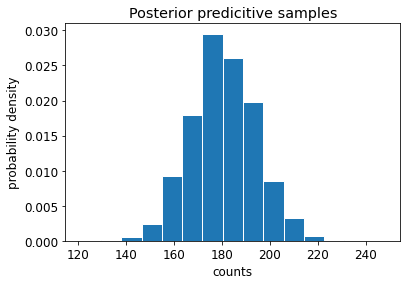

In [76]:
plt.figure()
plt.title('Posterior predicitive samples')
plt.xlabel('counts')
plt.ylabel('probability density')
for i in range(2):
    plt.hist(
        complete_pool_pred, bins = 15, edgecolor='white', density=True)
plt.show()

In the plot below, you can also see the posterior predictive distribution overlaid over the data we have. The mode of the posterior predictive is located around the higher bins of the data distribution meaning that the model predicts a plausible expected value of the counts, given the data provided.

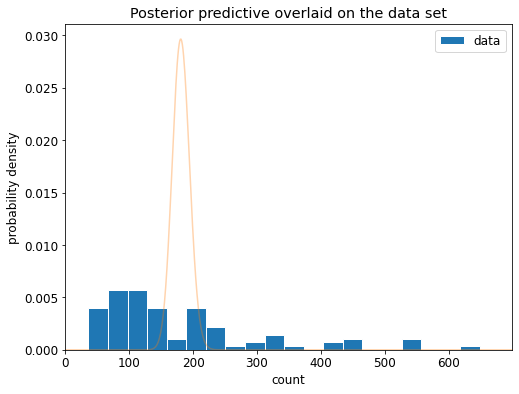

In [84]:
plot_x = np.arange(0, 700, 1)
plt.figure(figsize=(8, 6))
plt.hist(lst, bins=20, density=True, edgecolor='white', label='data')
plt.title('Posterior predictive overlaid on the data set')
plt.xlabel('count')
plt.ylabel('probability density')
plt.plot(plot_x, sts.poisson.pmf(k=plot_x, mu=complete_pool_post[i]), color='C1', alpha=1/3,label='posterior samples' if i == 0 else None)
plt.xlim(plot_x[0], plot_x[-1])
plt.legend()
plt.show()

## Predicting unknown cells using complete pooling 

Finally, let's find out the counts for the cells we don't know. As I described in the strategy step, to do so, we need to sample posterior values of lambda and use them to build a new Poisson model:

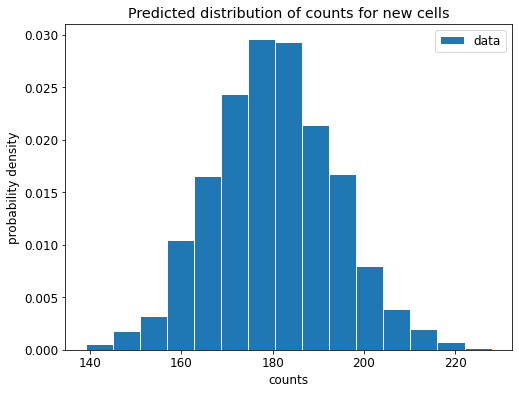

In [111]:
lams = complete_inference.posterior.lam.values.flatten()
counts = sts.poisson.rvs(lams)

plt.figure(figsize=(8, 6))
plt.title('Predicted distribution of counts for new cells')
plt.xlabel('counts')
plt.ylabel('probability density')
plt.hist(counts, bins = 15, density = True, edgecolor='white', label='data') 
plt.legend()
plt.show()

After we have the distribution, we can sample 9 counts from it, which will be our final predictions of the counts:

### Sampling 9 random counts for the missing cells

In [105]:
sample_idx = rd.sample(range(4000), 9)
print('Predicted nine counts', [counts[i] for i in sample_idx])

Predicted nine counts [127, 204, 54, 216, 177, 54, 150, 254, 281]


In [112]:
print('Desriptive statistics of mean and variance', np.mean(counts), np.std(counts))

Desriptive statistics of mean and variance 180.23475 13.51346152684426


# Partial Pooling

Now, let's apply partial pooling. When we use this strategy instead of the previously described complete pooling, we set the prior that allows each unit to have different parameters for the distributions that describe their counts. It lets us get different expected values for every count of plants without treating all the cells as fully independent. This model works for us because it is hard to assume that every cell will have almost identical counts. Besides, when we look at each cell, we do not account for its neighbors to predict similar counts, which means we still have to treat them as somewhat independent units. 

To achieve the goal of having different parameters for the various cells, we first set the overall prior used for the different priors for all the counts. I am using the same Exponential prior distributions here for the same reasons described in the Complete pooling section. However, now I set two distributions: (1) the overall higher-level lambda_bar prior has the same parameter lambda 1/400, and (2) the prior distributions lam for each cell, which has its parameter lambda equal to 1/lambda_bar because, as we mentioned before, the lambda_bar will be a big number that we have to plug into 1/lam to get the required high-value expected counts for all the cells. 

## Building a model 2.0

In [87]:
with pm.Model() as partial_pool:
    lam_bar = pm.Exponential('lam_bar', lam=1/400) #twice the medium expected
    lam = pm.Exponential('lam', lam=1/lam_bar, shape = len(lst))
    pm.Poisson('counts', lam, observed = lst)

In [88]:
with partial_pool:
    partial_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_bar, lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 303 seconds.


## Checking the reliability of the sampler 2.0

Below, I am checking if my sampler does a good job on partial pooling as well. Again, all r-hats are equal to 1, all ess values are high, and all the rank plots for all chains are close to being uniform and cover the same ranges. Therefore, computational errors are not very likely for this model as well. 

<b> Posterior summary for complete pooling model  

In [89]:
az.summary(partial_inference)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam_bar,183.824,19.541,154.598,215.529,0.221,0.162,8187.0,3112.0,1.0
lam[0],101.525,9.902,85.407,116.951,0.130,0.092,5777.0,2600.0,1.0
lam[1],92.364,9.252,78.040,107.390,0.121,0.085,5790.0,2440.0,1.0
lam[2],547.589,23.003,511.113,584.570,0.271,0.192,7136.0,2596.0,1.0
lam[3],448.751,21.247,416.148,483.357,0.246,0.176,7488.0,2969.0,1.0
...,...,...,...,...,...,...,...,...,...
lam[86],69.689,8.258,56.862,83.146,0.106,0.076,6084.0,2700.0,1.0
lam[87],87.440,9.302,73.181,102.236,0.115,0.084,6606.0,3189.0,1.0
lam[88],54.661,7.395,42.701,66.231,0.081,0.058,8196.0,2489.0,1.0
lam[89],44.683,6.799,32.919,54.687,0.073,0.055,8897.0,2609.0,1.0


<b> Plot distribution and sampled values

array([[<AxesSubplot:title={'center':'lam_bar'}>,
        <AxesSubplot:title={'center':'lam_bar'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

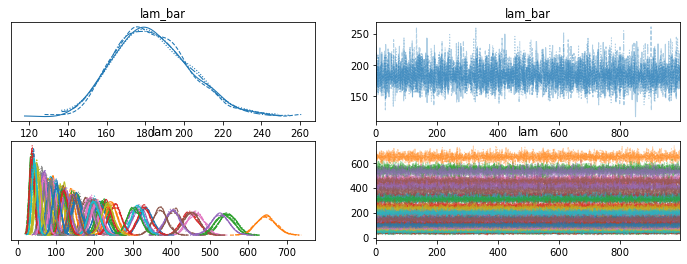

In [90]:
az.plot_trace(partial_inference, )

<b> Plot rank order statistics of chains.

C:\Users\kresh\AppData\Roaming\Python\Python38\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (92) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'lam_bar'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'lam\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'lam\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n8'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'lam\n9'}, xlabel='Rank (all c

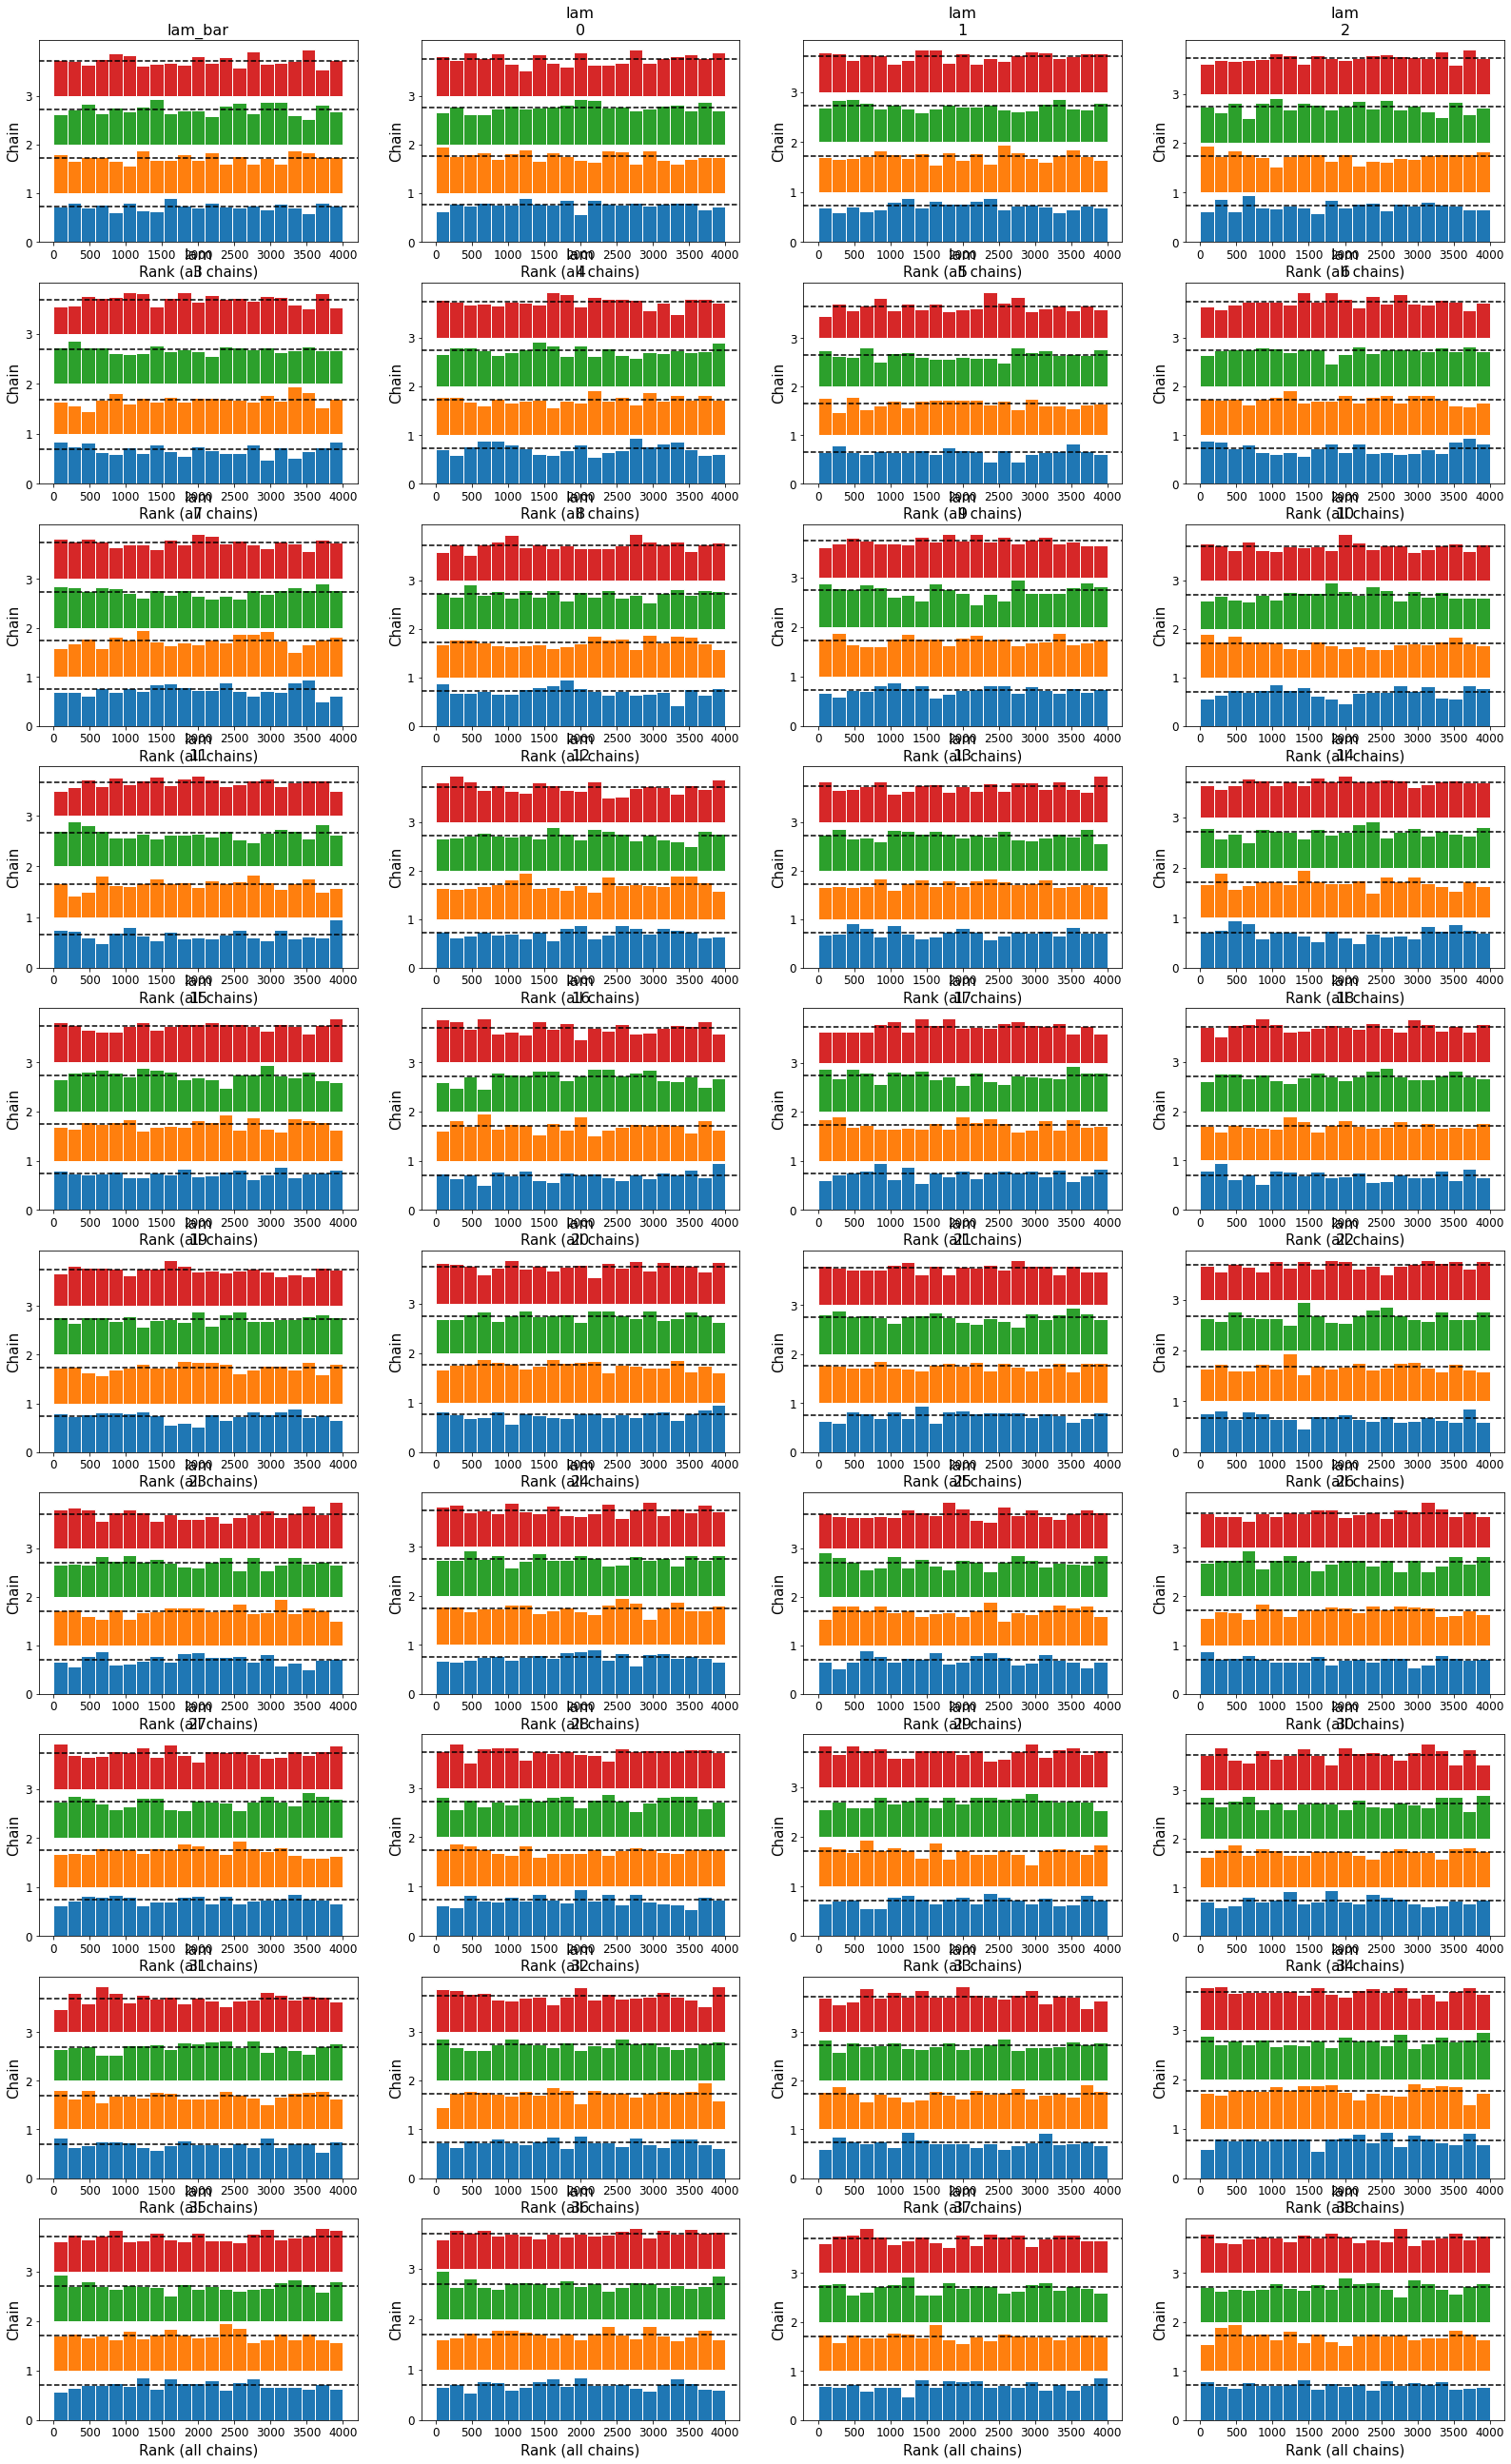

In [91]:
az.plot_rank(partial_inference, )

## Posterior over parameters

Here, I am plotting the posterior distribution over lambda_bar and lambda. 

Posterior lambda_bar has pretty much the same (or, better to say, very similar) distribution as the posterior over lambda in the complete pooling section because it describes the same expected values in each cell as the posterior over lambda we had previously. The posterior over lambda we have now for the partial pooling is different because we allow for more deviation. The values that might have been not that likely given the lambda_bar are now set as the expected values (or highly likely counts) for the plants per cell. 

The posterior over lambda in this pooling type has a much larger range of plausible values - from 0 to 700. This suggests that the values predicted by this model (the posterior predictive) will also be much broader, and the majority of the distribution's mass will be located between 0 and 200.

In [92]:
partial_pool_post_lam_b = partial_inference.posterior.lam_bar.values.flat
partial_pool_post_lam = partial_inference.posterior.lam.values.flat

C:\Users\kresh\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


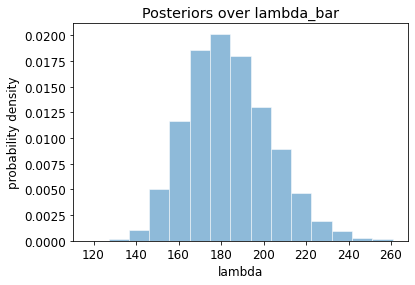

In [93]:
plt.figure()
plt.title('Posteriors over lambda_bar')
plt.xlabel('lambda')
plt.ylabel('probability density')
for i in range(2):
    plt.hist(
        partial_pool_post_lam_b, bins = 15, edgecolor='white', alpha=0.5, density=True)
plt.show()

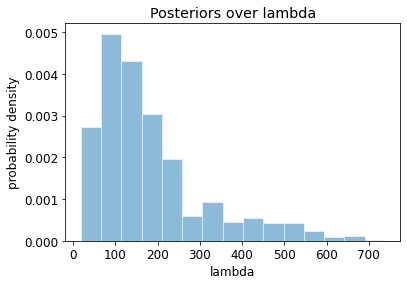

In [94]:
plt.figure()
plt.title('Posteriors over lambda')
plt.xlabel('lambda')
plt.ylabel('probability density')
for i in range(2):
    plt.hist(
        partial_pool_post_lam, bins = 15, edgecolor='white', alpha=0.5, density=True)
plt.show()

## Posterior predictive sample 2.0

You can see exactly what I was describing from the posterior predictive below. The predicted counts per cell are now distributed within the range [0, 700], and most values are between 0 and 200. Posterior predictive looks very similar to the posterior over lambda because it is a distribution of the expected counts, which lambda itself represents in the Poisson distribution.

In [99]:
with partial_pool:
    partial_pool_sample = pm.sample_posterior_predictive(partial_inference)

In [100]:
partial_pool_pred = partial_pool_sample.posterior_predictive.counts.values.flat 

C:\Users\kresh\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


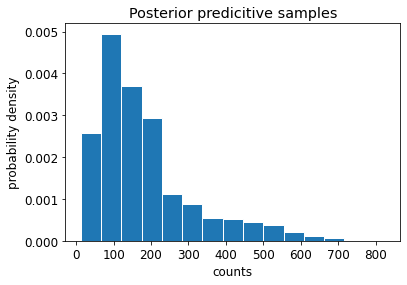

In [101]:
plt.figure()
plt.title('Posterior predicitive samples')
plt.xlabel('counts')
plt.ylabel('probability density')
for i in range(2):
    plt.hist(
        partial_pool_pred, bins = 15, edgecolor='white', density=True)
plt.show()

In the plots below, you can also see the posterior predictive distributions for all the cells overlaid over the data. We can see that all the posterior predictive distributions are different and located within the range of the data. This reassures us that we did a good job building a hierarchical model that set different distributions for all the groups.

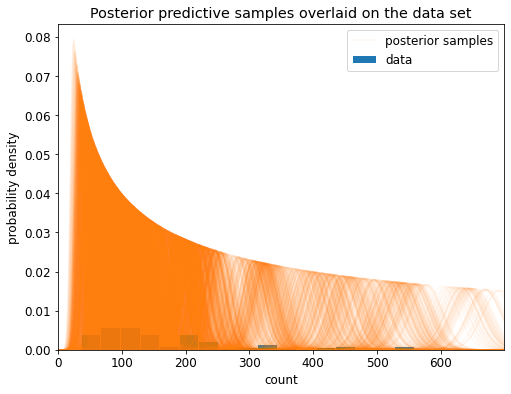

In [48]:
plot_x = np.arange(0, 700, 1)
plt.figure(figsize=(8, 6))
plt.hist(lst, bins=20, density=True, edgecolor='white', label='data')
plt.title('Posterior predictive samples overlaid on the data set')
plt.xlabel('count')
plt.ylabel('probability density')
for i in range(len(partial_pool_post_lam_b)):
    plt.plot(plot_x, sts.poisson.pmf(k=plot_x, mu=partial_pool_post_lam[i]), color='C1', alpha=0.05, 
             label='posterior samples' if i == 0 else None)
plt.xlim(plot_x[0], plot_x[-1])
plt.legend()
plt.show()

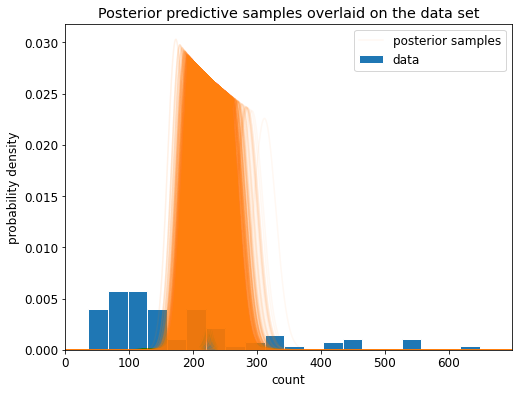

In [47]:
plot_x = np.arange(0, 700, 1)
plt.figure(figsize=(8, 6))
plt.hist(lst, bins=20, density=True, edgecolor='white', label='data')
plt.title('Posterior predictive samples overlaid on the data set')
plt.xlabel('count')
plt.ylabel('probability density')
for i in range(len(partial_pool_post_lam_b)):
    plt.plot(plot_x, sts.poisson.pmf(k=plot_x, mu=partial_pool_post_lam_b[i]), color='C1', alpha=0.05,
             label='posterior samples' if i == 0 else None)
plt.xlim(plot_x[0], plot_x[-1])
plt.legend()
plt.show()

## Predicting unknown cells using complete pooling 

Now, I will create a new Poisson similarly as I did in the complete pooling section. However, now I'll have to take one extra step. I'll have to use the posterior over lambda_bar to create the new posterior distribution over lambda. Only then will I be able to feed it into the further Poisson distribution to predict counts in the unknown independent cells. Notice that we don't have to create different Poisson distributions for every tile because we assume they are independent and not influenced by neighbors. Therefore, the estimation Poisson distribution will look the same for all of them.

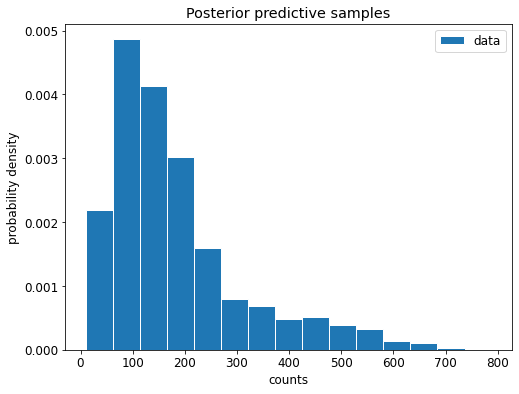

In [114]:
lam_bars = partial_inference.posterior.lam.values.flatten()
lams = sts.expon.rvs(lam_bars)
counts = sts.poisson.rvs(lams)

plt.figure(figsize=(8, 6))
plt.title('Posterior predictive samples')
plt.xlabel('counts')
plt.ylabel('probability density')
plt.hist(counts, bins = 15, density = True, edgecolor='white', label='data') 
plt.legend()
plt.show()

In [115]:
print('Desriptive statistics of mean and variance', np.mean(counts), np.std(counts))

Desriptive statistics of mean and variance 181.5513653846154 131.1727641258293


### Sampling 9 random counts for the missing cells

Finally, let's take a look at the random sample for each tile:

In [103]:
sample_idx = rd.sample(range(4000), 9)
print('Predicted nine counts', [counts[i] for i in sample_idx])

Predicted nine counts [203, 451, 229, 148, 507, 454, 169, 134, 104]


## Picking the favorite

I recommend using partial pooling over complete pooling to predict the counts in new unknown cells. Even though partial pooling is more computationally expensive, it allows us to treat all the tiles as independent and describe them using different Poisson distributions. Also, partial pooling provides a range for the posterior predictive that is more similar to the one we have in real life. While the range for the counts we have in data is [36, 650], complete pooling predicts it to be around [120, 240.] The range expected by partial pooling (around [0, 800]) is much more realistic. If we compare the descriptive statistics for partial pooling of variance and mean (131, 181) and for complete pooling (180, 13) partial pooling standard deviation is much closer to the one of the data we have (130.5, 181.)